In [1]:
"""
FastSLAM 2.0 example
author: Atsushi Sakai (@Atsushi_twi)
https://github.com/AtsushiSakai/PythonRobotics/blob/master/SLAM/FastSLAM2/fast_slam2.py
"""
from IPython import display
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Fast SLAM covariance
Q = np.diag([0.1, np.deg2rad(1.0)])**2
R = np.diag([1.0, np.deg2rad(20.0)])**2

#  Simulation parameter
Qsim = 0*np.diag([0.3, np.deg2rad(2.0)])**2
Rsim = np.diag([0.5, np.deg2rad(10.0)])**2
OFFSET_YAWRATE_NOISE = 0.05*np.random.uniform(-1,1,1)[0]

TRAJ_AMP = 0.0
TRAJ_FREQ = 2.0
INIT_YAW = TRAJ_AMP*TRAJ_FREQ

DT = 0.1  # time tick [s]
SIM_TIME = 10.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # LM srate size [x,y]
N_PARTICLE = 20  # number of particle
NTH = N_PARTICLE / 1.0  # Number of particle for re-sampling

FOV = 45  # field of view of range sensor [deg]

show_animation = True

In [3]:
class Particle:

    def __init__(self, N_LM):
        self.w = 1.0 / N_PARTICLE
        self.x = 0.0
        self.y = 0.0
        self.yaw = INIT_YAW
        self.P = np.eye(3)
        # landmark x-y positions
        self.lm = np.matrix(np.zeros((N_LM, LM_SIZE)))
        # landmark position covariance
        self.lmP = np.matrix(np.zeros((N_LM * LM_SIZE, LM_SIZE)))


def fast_slam2(particles, u, z):
    
    particles = predict_particles(particles, u)

    particles = update_with_observation(particles, z)

    particles = resampling(particles)
    
    return particles


def normalize_weight(particles):

    sumw = sum([p.w for p in particles])

    try:
        for i in range(N_PARTICLE):
            particles[i].w /= sumw
    except ZeroDivisionError:
        for i in range(N_PARTICLE):
            particles[i].w = 1.0 / N_PARTICLE

        return particles

    return particles


def calc_final_state(particles):

    xEst = np.zeros((STATE_SIZE, 1))

    particles = normalize_weight(particles)

    for i in range(N_PARTICLE):
        xEst[0, 0] += particles[i].w * particles[i].x
        xEst[1, 0] += particles[i].w * particles[i].y
        xEst[2, 0] += particles[i].w * particles[i].yaw

    xEst[2, 0] = pi_2_pi(xEst[2, 0])
    #  print(xEst)

    return xEst


def predict_particles(particles, u):

    for i in range(N_PARTICLE):
        px = np.zeros((STATE_SIZE, 1))
        px[0, 0] = particles[i].x
        px[1, 0] = particles[i].y
        px[2, 0] = particles[i].yaw
        ud = u + (np.matrix(np.random.randn(1, 2)) * R).T  # add noise
        px = motion_model(px, ud)
        particles[i].x = px[0, 0]
        particles[i].y = px[1, 0]
        particles[i].yaw = px[2, 0]

    return particles


def add_new_lm(particle, z, Q):

    r = z[0, 0]
    b = z[0, 1]
    lm_id = int(z[0, 2])

    s = math.sin(pi_2_pi(particle.yaw + b))
    c = math.cos(pi_2_pi(particle.yaw + b))

    particle.lm[lm_id, 0] = particle.x + r * c
    particle.lm[lm_id, 1] = particle.y + r * s

    # covariance
    Gz = np.matrix([[c, -r * s],
                    [s, r * c]])

    particle.lmP[2 * lm_id:2 * lm_id + 2] = Gz * Q * Gz.T

    return particle


def compute_jacobians(particle, xf, Pf, Q):
    dx = xf[0, 0] - particle.x
    dy = xf[1, 0] - particle.y
    d2 = dx**2 + dy**2
    d = math.sqrt(d2)

    zp = np.matrix([[d, pi_2_pi(math.atan2(dy, dx) - particle.yaw)]]).T

    Hv = np.matrix([[-dx / d, -dy / d, 0.0],
                    [dy / d2, -dx / d2, -1.0]])

    Hf = np.matrix([[dx / d, dy / d],
                    [-dy / d2, dx / d2]])

    Sf = Hf * Pf * Hf.T + Q

    return zp, Hv, Hf, Sf


def update_KF_with_cholesky(xf, Pf, v, Q, Hf):
    PHt = Pf * Hf.T
    S = Hf * PHt + Q

    S = (S + S.T) * 0.5
    SChol = np.linalg.cholesky(S).T
    SCholInv = np.linalg.inv(SChol)
    W1 = PHt * SCholInv
    W = W1 * SCholInv.T

    x = xf + W * v
    P = Pf - W1 * W1.T

    return x, P


def update_landmark(particle, z, Q):

    lm_id = int(z[0, 2])
    xf = np.matrix(particle.lm[lm_id, :]).T
    Pf = np.matrix(particle.lmP[2 * lm_id:2 * lm_id + 2, :])

    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dz = z[0, 0: 2].T - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    xf, Pf = update_KF_with_cholesky(xf, Pf, dz, Q, Hf)

    particle.lm[lm_id, :] = xf.T
    particle.lmP[2 * lm_id:2 * lm_id + 2, :] = Pf

    return particle


def compute_weight(particle, z, Q):

    lm_id = int(z[0, 2])
    xf = np.matrix(particle.lm[lm_id, :]).T
    Pf = np.matrix(particle.lmP[2 * lm_id:2 * lm_id + 2])
    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dz = z[0, 0: 2].T - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    S = particle.lmP[2 * lm_id:2 * lm_id + 2]
    try:
        invS = np.linalg.inv(S)
    except np.linalg.linalg.LinAlgError:
        print("singuler")
        return 1.0

    num = math.exp(-0.5 * dz.T * invS * dz)
    den = 2.0 * math.pi * math.sqrt(np.linalg.det(S))

    w = num / den

    return w


def proposal_sampling(particle, z, Q):

    lm_id = int(z[0, 2])
    xf = np.matrix(particle.lm[lm_id, :]).T
    Pf = np.matrix(particle.lmP[2 * lm_id:2 * lm_id + 2])
    # State
    x = np.matrix([[particle.x, particle.y, particle.yaw]]).T
    P = particle.P
    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    Sfi = np.linalg.inv(Sf)
    dz = z[0, 0: 2].T - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    Pi = np.linalg.inv(P)

    particle.P = np.linalg.inv(Hv.T * Sfi * Hv + Pi)  # proposal covariance
    x += particle.P * Hv.T * Sfi * dz  # proposal mean

    particle.x = x[0, 0]
    particle.y = x[1, 0]
    particle.yaw = x[2, 0]

    return particle


def update_with_observation(particles, z):

    for iz in range(len(z[:, 0])):

        lmid = int(z[iz, 2])

        for ip in range(N_PARTICLE):
            # new landmark
            if abs(particles[ip].lm[lmid, 0]) == 0:
                particles[ip] = add_new_lm(particles[ip], z[iz, :], Q)
            # known landmark
            else:
                w = compute_weight(particles[ip], z[iz, :], Q)
                particles[ip].w *= w

                particles[ip] = update_landmark(particles[ip], z[iz, :], Q)
                particles[ip] = proposal_sampling(particles[ip], z[iz, :], Q)

    return particles


def resampling(particles):
    """
    low variance re-sampling
    """
    
    particles = normalize_weight(particles)

    pw = []
    for i in range(N_PARTICLE):
        pw.append(particles[i].w)

    pw = np.matrix(pw)

    Neff = 1.0 / (pw * pw.T)[0, 0]  # Effective particle number
    
    if Neff < NTH:  # resampling
        
        wcum = np.cumsum(pw)
        base = np.cumsum(pw * 0.0 + 1 / N_PARTICLE) - 1 / N_PARTICLE
        resampleid = base + np.random.rand(base.shape[1]) / N_PARTICLE
        
        inds = []
        ind = 0
        for ip in range(N_PARTICLE):
            while ((ind < wcum.shape[1] - 1) and (resampleid[0, ip] > wcum[0, ind])):
                ind += 1
            inds.append(ind)

        tparticles = particles[:]
        for i in range(len(inds)):
            particles[i].x = tparticles[inds[i]].x
            particles[i].y = tparticles[inds[i]].y
            particles[i].yaw = tparticles[inds[i]].yaw
            particles[i].lm = tparticles[inds[i]].lm[:, :]
            particles[i].lmP = tparticles[inds[i]].lmP[:, :]
            particles[i].w = 1.0 / N_PARTICLE

    return particles


def calc_input(time):

    v = np.sqrt(1 + (TRAJ_AMP*TRAJ_FREQ*np.cos(TRAJ_FREQ*time))**2)
    yawrate = -TRAJ_AMP*TRAJ_FREQ*TRAJ_FREQ*np.sin(TRAJ_FREQ*time)

    u = np.matrix([v, yawrate]).T

    return u


def observation(xTrue, xd, u, RFID):

    xTrue = motion_model(xTrue, u)
    z = np.matrix(np.zeros((0, 3)))

    for i in range(len(RFID[:, 0])):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = math.atan2(dy, dx) - xTrue[2, 0]
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.matrix([dn, pi_2_pi(anglen), i])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1] + OFFSET_YAWRATE_NOISE
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):

    F = np.matrix([[1.0, 0, 0],
                   [0, 1.0, 0],
                   [0, 0, 1.0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT]])

    x = F * x + B * u

    x[2, 0] = pi_2_pi(x[2, 0])

    return x


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

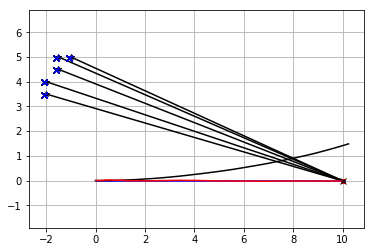

In [4]:
time = 0.0

# RFID positions [x, y]
RFID = np.array([[-2.0, 4.0],
                 [-1.0, 5.0],
                 [-1.5, 4.5],
                 [-2.0, 3.5],
                 [-1.5, 5.0]
                ])
N_LM = RFID.shape[0]

# State Vector [x y yaw]'
xEst = np.matrix(np.zeros((STATE_SIZE, 1)))
xTrue = np.matrix(np.zeros((STATE_SIZE, 1)))
xDR = np.matrix(np.zeros((STATE_SIZE, 1)))  # Dead reckoning
xEst[2], xTrue[2], xDR[2] = INIT_YAW, INIT_YAW, INIT_YAW

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue

particles = [Particle(N_LM) for i in range(N_PARTICLE)]

err_array = []

while time <= SIM_TIME:
    time += DT
    u = calc_input(time)

    xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

    particles = fast_slam2(particles, ud, z)
    
    xEst = calc_final_state(particles)

    x_state = xEst[0: STATE_SIZE]

    # store data history
    hxEst = np.hstack((hxEst, x_state))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))

    display.clear_output(wait=True)
    pos_err = np.linalg.norm((x_state-xTrue)[0:2])
    err_array.append(pos_err)
        
    if show_animation:
        plt.plot(RFID[:, 0], RFID[:, 1], "*k")

        for iz in range(len(z[:, 0])):
            lmid = int(z[iz, 2])
            plt.plot([xEst[0, 0], RFID[lmid, 0]], [
                     xEst[1, 0], RFID[lmid, 1]], "-k")

        for i in range(N_PARTICLE):
            plt.plot(particles[i].x, particles[i].y, ".r")
            plt.plot(particles[i].lm[:, 0], particles[i].lm[:, 1], "xb")

        plt.plot(np.array(hxTrue[0, :]).flatten(),
                 np.array(hxTrue[1, :]).flatten(), "-b")
        plt.plot(np.array(hxDR[0, :]).flatten(),
                 np.array(hxDR[1, :]).flatten(), "-k")
        plt.plot(np.array(hxEst[0, :]).flatten(),
                 np.array(hxEst[1, :]).flatten(), "-r")

        plt.plot(xEst[0], xEst[1], "xk")
        plt.axis("equal")
        plt.grid(True)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.pause(0.001)

In [5]:
time += DT
u = calc_input(time)
particles = predict_particles(particles, u)
x_arr, y_arr, yaw_arr = [], [], []
for pq in particles:
    x_arr.append(pq.x)
    y_arr.append(pq.y)
    yaw_arr.append(pq.yaw)

print(np.cov(x_arr), np.cov(y_arr), np.cov(yaw_arr))

0.007613794650916278 4.972038825311161e-08 0.00013830238617687125


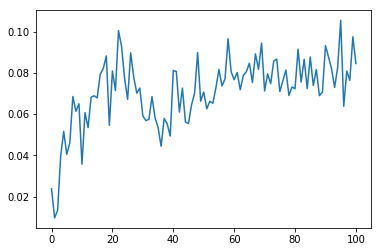

In [6]:
plt.plot(err_array)

In [7]:
print(np.random.random())

0.17373242179688253
